In [1]:

import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")
import joblib
from numpy.random import seed
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers



Using TensorFlow backend.


## Loading the dataset

In [2]:
# Loading the data set 
data=pd.read_csv('machine_0.csv')
data.isnull().sum()

Unnamed: 0    0
0             0
1             0
2             0
3             0
dtype: int64

###  Data Cleaning

In [3]:
# Renaming the first column to 'Date' 
data=data.rename(columns = {'Unnamed: 0':'Date'})


In [4]:
data

,Date,0,1,2,3
0,2019-01-01 00:00:00.000000000,12.626096,8.803120,-11.809200,10.083961
1,2019-01-01 08:00:09.603201067,10.831994,2.816327,11.554778,21.892853
2,2019-01-01 16:00:19.206402134,21.083510,-0.672645,-17.839178,-1.349024
3,2019-01-02 00:00:28.809603201,32.294495,6.525132,-13.498586,-4.250752
4,2019-01-02 08:00:38.412804268,28.057100,3.691359,21.984744,13.670561
...,...,...,...,...,...
2995,2021-09-25 15:59:21.587195728,0.004364,-0.010959,-0.007210,0.012390
2996,2021-09-25 23:59:31.190396800,0.004077,0.000165,-0.003772,0.010053
2997,2021-09-26 07:59:40.793597872,0.007702,-0.014708,-0.011722,0.001334
2998,2021-09-26 15:59:50.396798944,-0.008149,0.000107,-0.017914,0.010599


In [5]:
# removing micro seconds

data['Date'] = data['Date'].astype('datetime64[s]')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3000 non-null   datetime64[ns]
 1   0       3000 non-null   float64       
 2   1       3000 non-null   float64       
 3   2       3000 non-null   float64       
 4   3       3000 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 117.3 KB


In [6]:

# Checking for missing values of day's 

d1 = datetime.strptime(str(data.iloc[0,0]), "%Y-%m-%d %H:%M:%S")
d2 = datetime.strptime(str(data.iloc[-1,0]), "%Y-%m-%d %H:%M:%S")
diff_btw_dates = abs((d2 - d1).days)

print(diff_btw_dates)


len(data)# Therefore there are no missing values in the dat 

1000


3000

In [7]:
data

,Date,0,1,2,3
0,2019-01-01 00:00:00,12.626096,8.803120,-11.809200,10.083961
1,2019-01-01 08:00:09,10.831994,2.816327,11.554778,21.892853
2,2019-01-01 16:00:19,21.083510,-0.672645,-17.839178,-1.349024
3,2019-01-02 00:00:28,32.294495,6.525132,-13.498586,-4.250752
4,2019-01-02 08:00:38,28.057100,3.691359,21.984744,13.670561
...,...,...,...,...,...
2995,2021-09-25 15:59:21,0.004364,-0.010959,-0.007210,0.012390
2996,2021-09-25 23:59:31,0.004077,0.000165,-0.003772,0.010053
2997,2021-09-26 07:59:40,0.007702,-0.014708,-0.011722,0.001334
2998,2021-09-26 15:59:50,-0.008149,0.000107,-0.017914,0.010599


In [8]:
# setting Date column as index and combining the three reading of each day to one  
df=data.set_index('Date').groupby(pd.Grouper(freq='D')).mean()



## Data Visualization 

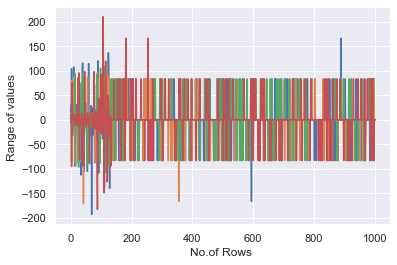

In [9]:
plt.plot(range(len(df)), df)

plt.xlabel('No.of Rows ')
plt.ylabel('Range of values ') 
plt.show()


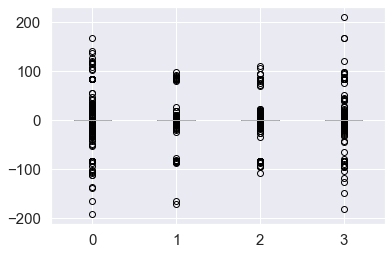

In [10]:
# Checking the outliers
boxplot = df.boxplot(column=['0','1','2','3'],grid=True,  fontsize=15)

In [11]:
df.describe()

,0,1,2,3
count,1001.000000,1001.000000,1001.000000,1001.000000
mean,-0.815198,-1.090204,1.266682,0.165690
std,35.458904,31.525365,31.821421,33.565671
min,-193.339317,-171.266124,-108.287806,-183.251082
25%,-0.005871,-0.005970,-0.004870,-0.004708
50%,-0.000227,-0.000313,0.000615,0.000382
75%,0.004948,0.005767,0.006091,0.005421
max,166.668811,96.936192,109.841484,210.283234


checking for the anomalies using standard deviation(std) . If the std is really high then the data contains anamolies.

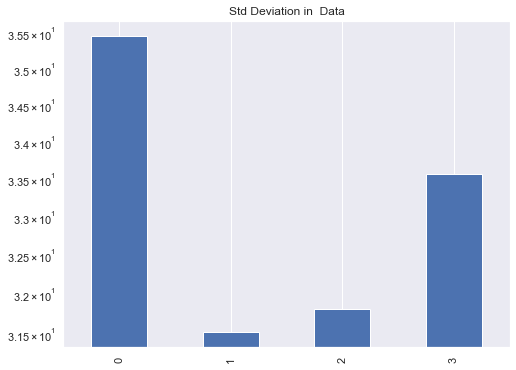

In [12]:
df[['0','1','2','3']].std().plot(kind='bar', figsize=(8,6), logy=True, title="Std Deviation in  Data")

The variation in standard deviation very high  because of outliers present in the data  and we  have to remove them. 

###  Data Transformation 

In [13]:
df1=df

# Applying sin () function in order to scale the values from high ranges to '-1 to 1' range . 
f1=lambda x: np.sin(x)
df=f1(df1)

In [14]:
df # We can observe that the data ranges from -1 to 1 range

,0,1,2,3
Date,,,,
2019-01-01,0.758340,-0.485855,0.249327,-0.706461
2019-01-02,-0.988122,0.789650,-0.723446,0.845197
2019-01-03,0.822632,-0.112853,-0.039107,-0.391493
2019-01-04,-0.604543,0.763905,-0.261041,-0.998848
2019-01-05,0.660116,-0.947052,0.115211,-0.443688
...,...,...,...,...
2021-09-23,-0.004802,0.007367,-0.004618,0.007794
2021-09-24,0.003081,0.996114,-0.013694,-0.996637
2021-09-25,0.001425,-0.001587,-0.002294,0.007431


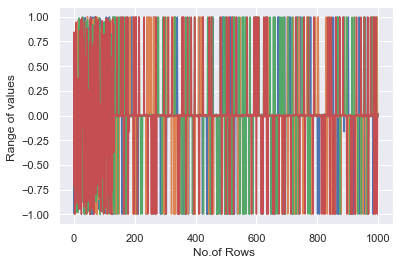

In [15]:
# After data transformation the range of data is show in the below graph
plt.plot(range(len(df)), df)
plt.xlabel('No.of Rows ')
plt.ylabel('Range of values ')
plt.show()

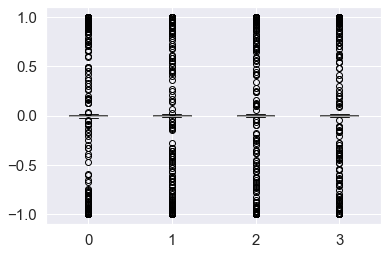

In [16]:
boxplot = df.boxplot(column=['0','1','2','3'],grid=True,  fontsize=15)

# Train, Test split
 test=27%

In [17]:
train = df['2019-01-01 ': '2020-12-31 ']
test = df['2021-01-01 ':]
print("Training dataset shape:", train.shape)
print("Test dataset shape:", test.shape)

Training dataset shape: (731, 4)
Test dataset shape: (270, 4)


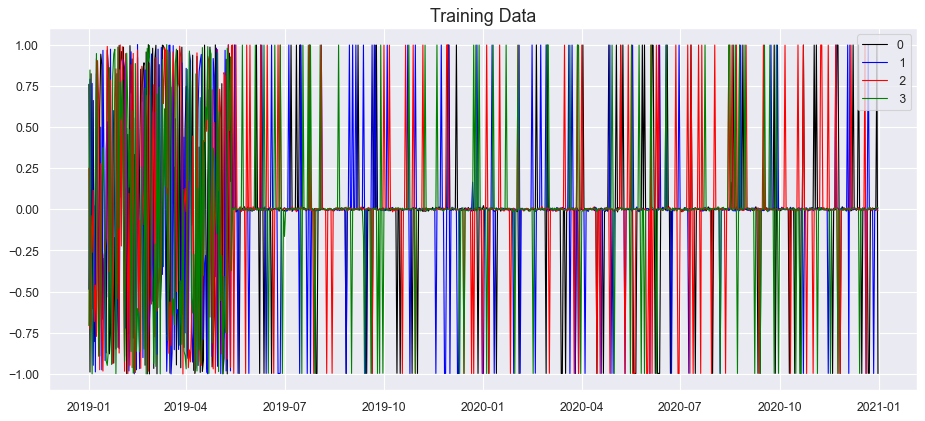

In [18]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train['0'], label='0', color='black', animated = True, linewidth=1)
ax.plot(train['1'], label=' 1', color='blue', animated = True, linewidth=1)
ax.plot(train['2'], label=' 2', color='red', animated = True, linewidth=1)
ax.plot(train['3'], label=' 3', color='green', animated = True, linewidth=1)

plt.legend(loc='top right')
ax.set_title('Training Data', fontsize=16)
plt.show()

## Test data vizualization

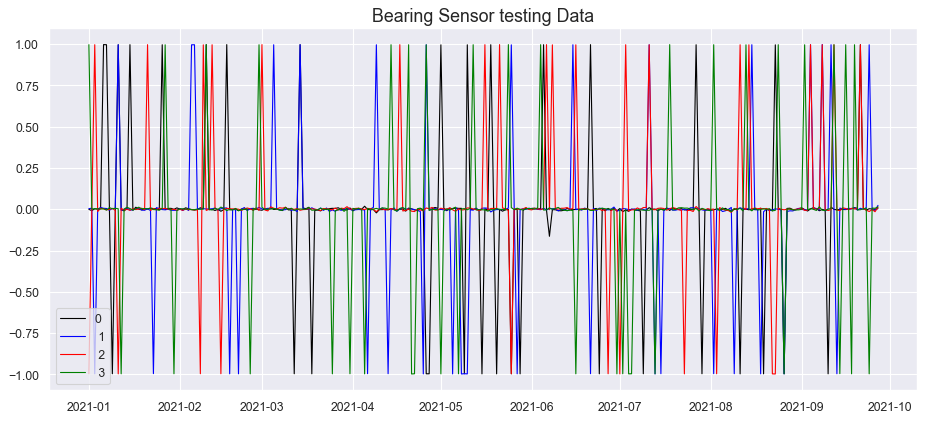

In [19]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(test['0'], label='0', color='black', animated = True, linewidth=1)
ax.plot(test['1'], label=' 1', color='blue', animated = True, linewidth=1)
ax.plot(test['2'], label=' 2', color='red', animated = True, linewidth=1)
ax.plot(test['3'], label=' 3', color='green', animated = True, linewidth=1)

plt.legend(loc='lower left')
ax.set_title('Bearing Sensor testing Data', fontsize=16)
plt.show()

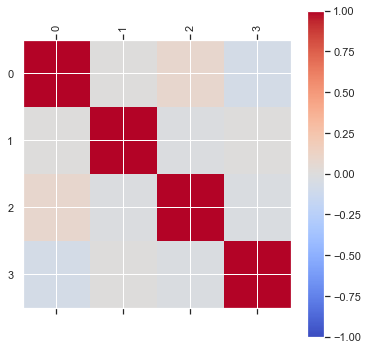

In [20]:
# Finding correlation of between dependent variables 
corr =train.corr()

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)

ticks = np.arange(0,len(train.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(train.columns)
ax.set_yticklabels(train.columns)
plt.show()

In [21]:

# normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
scaler_filename = "scaler_data"
joblib.dump(scaler, scaler_filename)

['scaler_data']

In [22]:

# reshape inputs for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (731, 1, 4)
Test data shape: (270, 1, 4)


In [23]:
# Creating autoencoder network (LSTM) model
def lstm_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(20, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(20, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [24]:

# instantiating autoencoder model
model = lstm_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 4)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 20)             2000      
_________________________________________________________________
lstm_2 (LSTM)                (None, 4)                 400       
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 1, 4)              0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 4)              144       
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 20)             2000      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 4)              84  

In [25]:
# fit the model to the data
epochs = 70
batch_size = 10
history = model.fit(X_train, X_train, epochs=epochs, batch_size=batch_size,
                    validation_split=0.05).history

Train on 694 samples, validate on 37 samples
Epoch 1/70
694/694 [==============================] - 3s 4ms/step - loss: 0.4626 - val_loss: 0.4070
Epoch 2/70
694/694 [==============================] - 0s 631us/step - loss: 0.3358 - val_loss: 0.1095
Epoch 3/70
694/694 [==============================] - 0s 608us/step - loss: 0.1288 - val_loss: 0.0794
Epoch 4/70
694/694 [==============================] - 0s 624us/step - loss: 0.1236 - val_loss: 0.0788
Epoch 5/70
694/694 [==============================] - 0s 465us/step - loss: 0.1230 - val_loss: 0.0772
Epoch 6/70
694/694 [==============================] - 0s 628us/step - loss: 0.1226 - val_loss: 0.0763
Epoch 7/70
694/694 [==============================] - 0s 649us/step - loss: 0.1226 - val_loss: 0.0754
Epoch 8/70
694/694 [==============================] - 0s 652us/step - loss: 0.1223 - val_loss: 0.0757
Epoch 9/70
694/694 [==============================] - 0s 655us/step - loss: 0.1222 - val_loss: 0.0742
Epoch 10/70
694/694 [==================

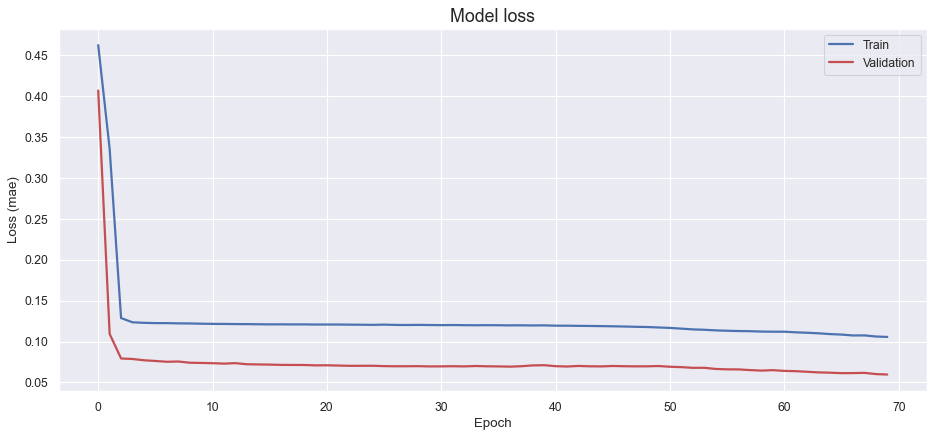

In [26]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

(0.0, 0.5)

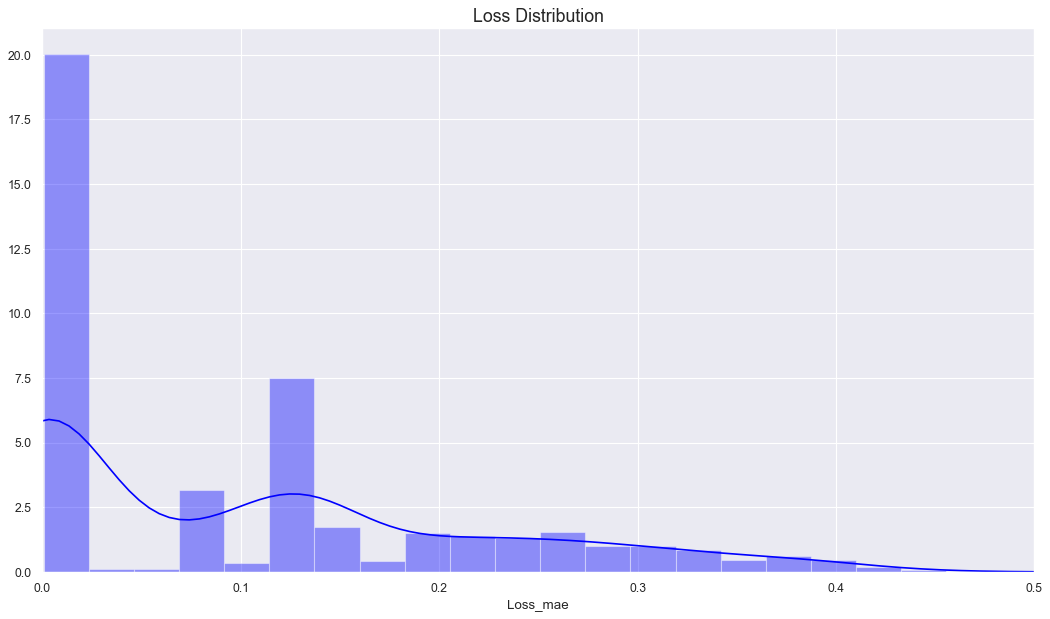

In [27]:
# plotting  loss distribution of  training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])

In [28]:

# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)

# I took threshold as 0.19(by observing the above graph) because after this point I am considering the machine as failure
scored['Threshold'] = 0.19
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
#scored.to_csv('scored.csv')
scored

,Loss_mae,Threshold,Anomaly
Date,,,
2021-01-01,0.202808,0.19,True
2021-01-02,0.003879,0.19,False
2021-01-03,0.235373,0.19,True
2021-01-04,0.001690,0.19,False
2021-01-05,0.002246,0.19,False
...,...,...,...
2021-09-23,0.003316,0.19,False
2021-09-24,0.252384,0.19,True
2021-09-25,0.001446,0.19,False


In [29]:
results_df=scored

In [30]:
# categorising the values to Faulty,Failed,Normal condition of machine - 0  for test data
    
results_df.loc[(results_df['Loss_mae'] <0.2 ) & (results_df['Loss_mae']>0.07), 'labeled'] = 'Faulty'  
results_df.loc[(results_df['Loss_mae']>0.19), 'labeled'] = 'Failed'
results_df.loc[(results_df['Loss_mae']<0.07), 'labeled'] = 'NOrmal'  

print (results_df)

            Loss_mae  Threshold  Anomaly labeled
Date                                            
2021-01-01  0.202808       0.19     True  Failed
2021-01-02  0.003879       0.19    False  NOrmal
2021-01-03  0.235373       0.19     True  Failed
2021-01-04  0.001690       0.19    False  NOrmal
2021-01-05  0.002246       0.19    False  NOrmal
...              ...        ...      ...     ...
2021-09-23  0.003316       0.19    False  NOrmal
2021-09-24  0.252384       0.19     True  Failed
2021-09-25  0.001446       0.19    False  NOrmal
2021-09-26  0.001194       0.19    False  NOrmal
2021-09-27  0.004170       0.19    False  NOrmal

[270 rows x 4 columns]


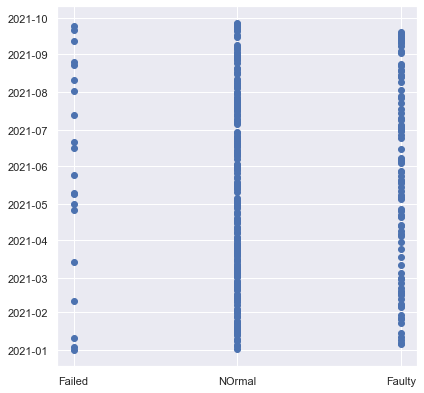

In [31]:
# From the below graph we can observe how many failures and fault  of a machine can occur per each month

fig= plt.figure(figsize=(10,10))
axes=fig.add_axes([0.1,0.1,0.5,0.5])
axes.scatter(results_df['labeled'],results_df.index)
plt.show()

In [32]:
results_df.to_csv('results_df.csv')

In [33]:
# calculate the same metrics on  training set 
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index

scored_train = pd.DataFrame(index=train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = 0.19
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

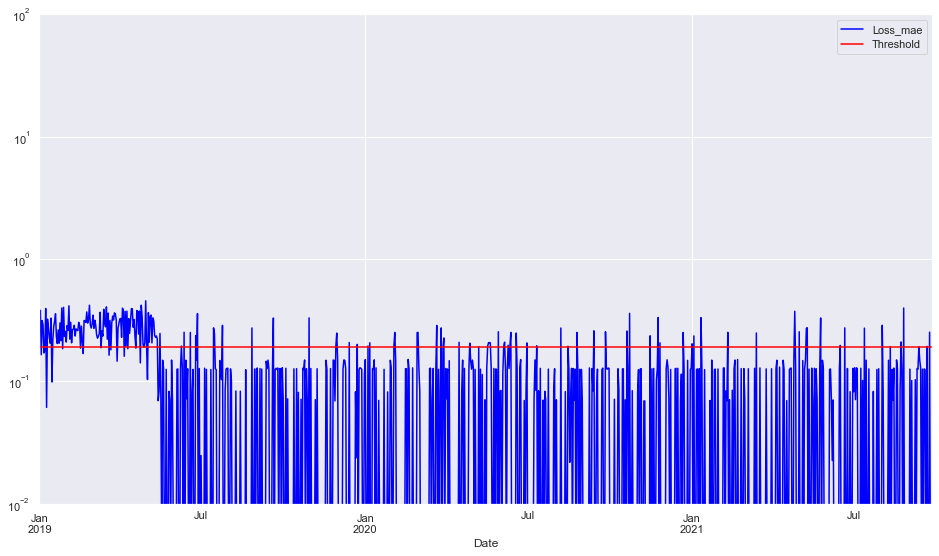

In [34]:
# plot machine failure time plot
scored.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], \
            color=['blue','red'])

In the graph  the red line is called threshold(>0.19) , beyond that threshold line we have to consider the machine going into failed state .